In [8]:
import networkx as nx
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [10]:
plt.rcParams["figure.figsize"] = (20,3)

In [11]:
from shared.constants import DatasetPath
from datasets.schema import DatasetSchema
from datasets.loading import load_igraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [12]:
DATASET = DatasetPath('sx-mathoverflow')
schema = DatasetSchema.load_schema(DATASET.name)
G = load_igraph(schema)

In [13]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: False
Has edge timestamp: True


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [14]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

In [15]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

No node timestamp data available


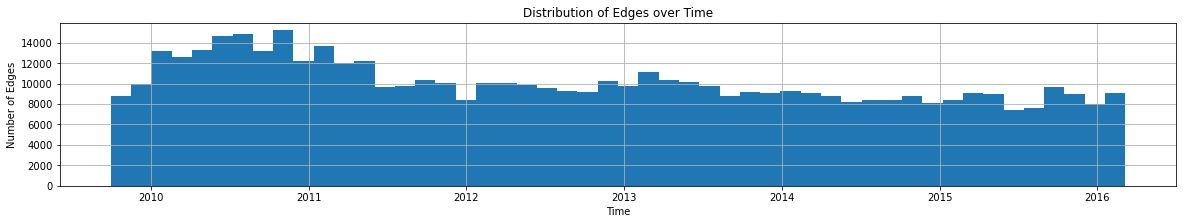

In [16]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

# Global Statistics

In [17]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 24818
Number of Edges: 506550
Density: 0.0016448877050864127


In [18]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [19]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 40.821178177129504
Median Degree: 6.0


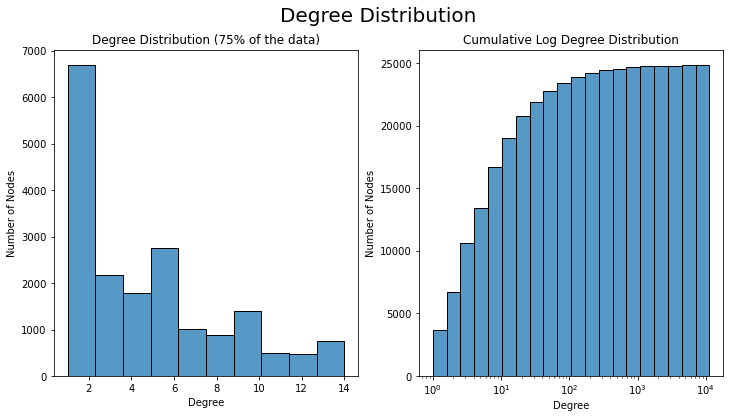

In [20]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [21]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,11309,1946
1,8599,290
2,8412,6094
3,7998,11142
4,6399,297
5,5360,763
6,5167,1409
7,5132,2841
8,4872,18060
9,4832,2926


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [22]:
# Use the largest connected component
G_cc = G.clusters().giant()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [23]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.441
Diameter: 9


In [24]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

,degree_centrality,betweenness_centrality,eigenvector_centrality,page_rank,transitivity
count,24668.000000,24668.000000,2.466800e+04,24668.000000,18780.000000
mean,0.001664,0.000092,2.047859e-03,0.000041,0.412439
std,0.009453,0.004769,6.028772e-03,0.000147,0.334212
min,0.000041,0.000000,1.365486e-10,0.000008,0.000000
25%,0.000081,0.000000,2.157115e-04,0.000010,0.156079
50%,0.000243,0.000000,5.705857e-04,0.000015,0.333333
75%,0.000608,0.000000,1.394757e-03,0.000024,0.666667
max,0.458467,0.662118,1.355040e-01,0.005247,1.000000


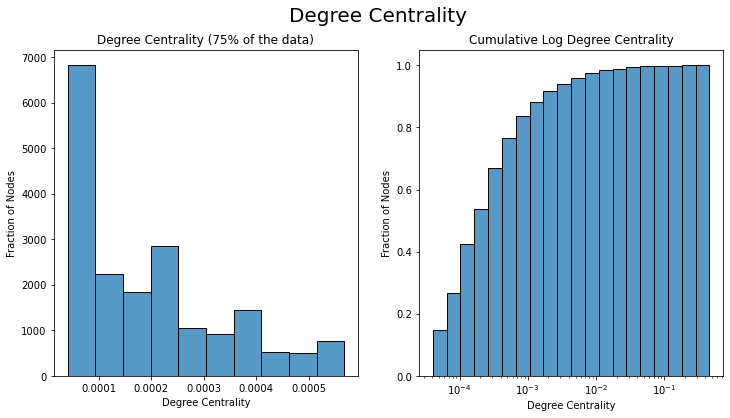

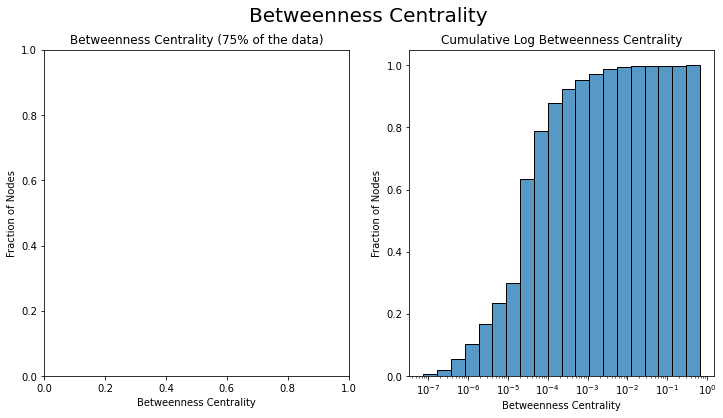

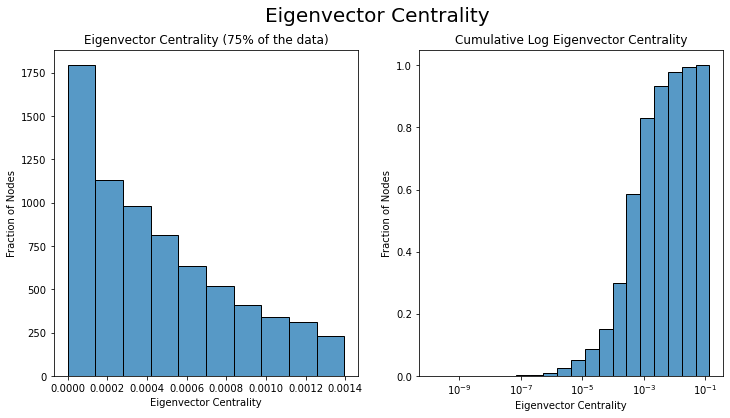

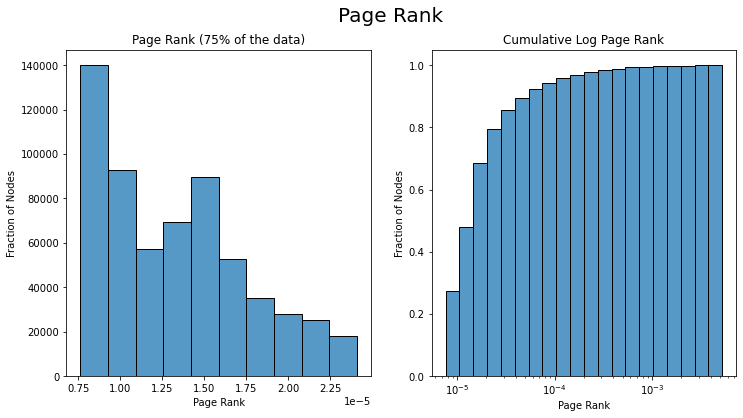

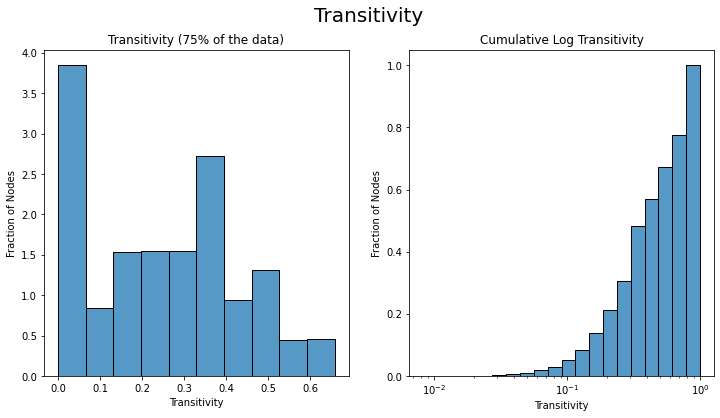

In [25]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [26]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.458467,1946,0.662118,4556,0.135504,290,0.005247,11142,1.0,84022
1,0.348603,290,0.337882,3493,0.113728,1409,0.004733,290,1.0,49642
2,0.341022,6094,0.031396,11142,0.108523,297,0.004519,763,1.0,34924
3,0.324239,11142,0.020747,763,0.107152,11142,0.003804,3684,1.0,66335
4,0.259415,297,0.020487,6094,0.101428,121,0.003612,6094,1.0,49349
5,0.217294,763,0.020096,3684,0.101090,763,0.003428,121,1.0,15988
6,0.209470,1409,0.019340,290,0.095745,6094,0.003315,1409,1.0,15978
7,0.208051,2841,0.017910,1946,0.094643,2926,0.003228,297,1.0,15983
8,0.197511,18060,0.016054,1465,0.093651,1149,0.003115,1946,1.0,6123
9,0.195889,2926,0.015453,6101,0.092679,3684,0.003026,2926,1.0,80579


## Connected Components Statistics

In [27]:
print(f'Number of Connected Components: {len(G.components())}')
largest_cc = G.components().giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 104
Size of the largest component: 24668


Text(0.5, 1.0, 'Connected Components')

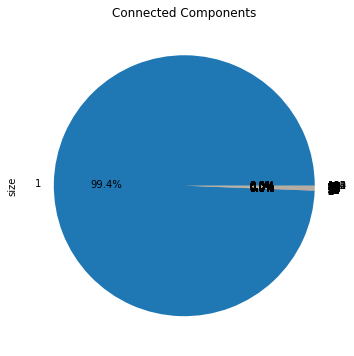

In [28]:
df_tmp = pd.DataFrame([{'size': len(c)} for i,c in enumerate(G.components())], index=range(1,len(G.components())+1))
ax = df_tmp.plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [29]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 1


,type,count,degree_avg,degree_median
User,User,24818,40.821178,6.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

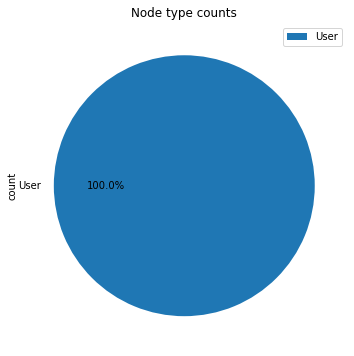

In [30]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

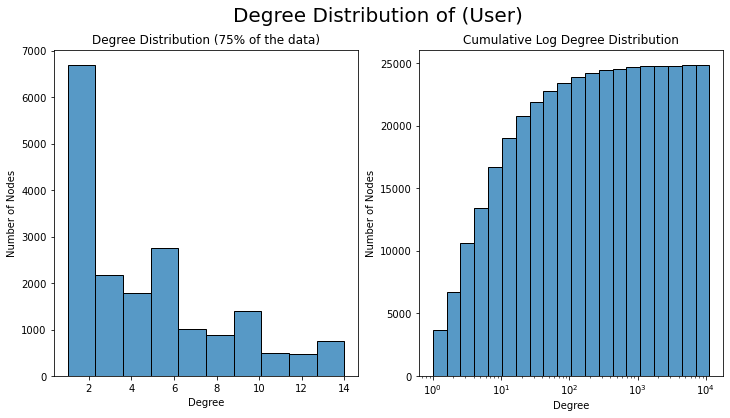

In [31]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [32]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (User)


,value,label
0,11309,1946
1,8599,290
2,8412,6094
3,7998,11142
4,6399,297
5,5360,763
6,5167,1409
7,5132,2841
8,4872,18060
9,4832,2926


### Edge Type Statistics

In [33]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 3


,type,count
ANSWERED_QUESTION,ANSWERED_QUESTION,107581
COMMENTED_ON_QUESTION,COMMENTED_ON_QUESTION,203639
COMMENTED_ON_ANSWER,COMMENTED_ON_ANSWER,195330


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

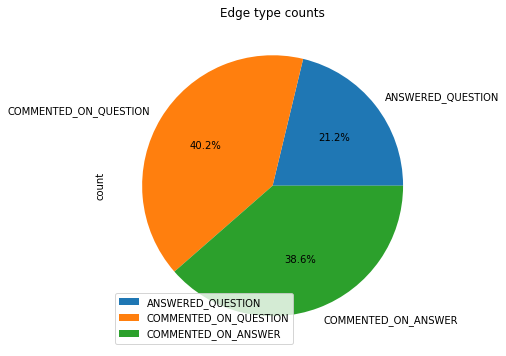

In [34]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [35]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [36]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for User


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.458467,1946,0.662118,4556,0.135504,290,0.005247,11142,1.0,80425
1,0.348603,290,0.337882,3493,0.113728,1409,0.004733,290,1.0,33029
2,0.341022,6094,0.031396,11142,0.108523,297,0.004519,763,1.0,11794
3,0.324239,11142,0.020747,763,0.107152,11142,0.003804,3684,1.0,11790
4,0.259415,297,0.020487,6094,0.101428,121,0.003612,6094,1.0,33177
5,0.217294,763,0.020096,3684,0.101090,763,0.003428,121,1.0,11785
6,0.209470,1409,0.019340,290,0.095745,6094,0.003315,1409,1.0,80081
7,0.208051,2841,0.017910,1946,0.094643,2926,0.003228,297,1.0,60757
8,0.197511,18060,0.016054,1465,0.093651,1149,0.003115,1946,1.0,60745
9,0.195889,2926,0.015453,6101,0.092679,3684,0.003026,2926,1.0,33218


# Clustering

## No Clustering Modularity

In [37]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [38]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.48027734342618345
Number of communities: 26


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

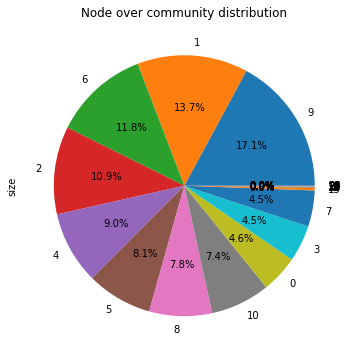

In [39]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [40]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.147768,1465,0.016054,1465,0.079519,1465,0.002482,1465,1.0,85768
1,0.099364,1345,0.006558,21684,0.068234,317,0.001612,1345,1.0,51250
2,0.091701,21684,0.005680,1345,0.061341,1345,0.001523,21684,1.0,23121
3,0.087242,1463,0.004403,317,0.060054,2051,0.001376,317,1.0,22344
4,0.081526,317,0.004317,1463,0.049532,1463,0.001206,1463,1.0,29775
5,0.068837,2349,0.003666,2051,0.049403,2349,0.001094,2051,1.0,62849
6,0.067580,1573,0.003207,1573,0.049200,21684,0.000893,1573,1.0,9052
7,0.063648,2051,0.002675,20787,0.043787,1573,0.000872,2349,1.0,21949
8,0.045486,1650,0.002502,6451,0.038384,35353,0.000846,20787,1.0,88026
9,0.040499,20787,0.002199,1650,0.036506,20787,0.000729,1650,1.0,12408


No node timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.118336,8430,0.012645,11260,0.071159,8799,0.002554,8430,1.0,68794
1,0.111809,25510,0.011426,1131,0.066665,8430,0.002550,11260,1.0,25957
2,0.109985,1131,0.010870,8430,0.063308,1131,0.002402,13650,1.0,13256
3,0.091864,8799,0.010685,13650,0.058065,6316,0.002140,25510,1.0,60426
4,0.089999,11260,0.010050,25510,0.057787,25510,0.002018,1131,1.0,85073
5,0.088742,13650,0.008563,4832,0.053670,4832,0.001809,4832,1.0,12457
6,0.073175,6316,0.006327,1898,0.047773,11260,0.001764,8799,1.0,69967
7,0.064742,4832,0.003985,11100,0.047497,13650,0.001630,11054,1.0,60430
8,0.063526,11054,0.003931,1044,0.042923,1898,0.001526,1898,1.0,78574
9,0.052175,1898,0.003189,22051,0.038722,1044,0.001078,6316,1.0,22348


No node timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.348603,290,0.662118,4556,0.135504,290,0.004733,290,1.0,11384
1,0.259415,297,0.019340,290,0.113728,1409,0.003428,121,1.0,1338
2,0.209470,1409,0.015453,121,0.108523,297,0.003315,1409,1.0,14203
3,0.185430,1149,0.013715,1409,0.101428,121,0.003228,297,1.0,16404
4,0.157255,121,0.012322,297,0.093651,1149,0.002199,1149,1.0,12763
5,0.108647,66,0.011435,1149,0.074372,1459,0.001689,1847,1.0,7145
6,0.102972,1450,0.009366,1847,0.070626,1532,0.001533,66,1.0,19564
7,0.092350,1532,0.005944,66,0.069734,66,0.001351,1532,1.0,891
8,0.084120,45,0.004722,3,0.069733,5740,0.001331,1459,1.0,17448
9,0.077067,5740,0.003922,5740,0.066039,1450,0.001269,5740,1.0,4591


No node timestamp data available
Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.122796,1384,0.007315,2290,0.075633,3272,0.001748,2290,1.0,83738
1,0.115782,2874,0.005354,9317,0.066443,1384,0.001616,3272,1.0,23424
2,0.100255,3272,0.005193,3272,0.063198,2290,0.001343,2874,1.0,8044
3,0.088053,2290,0.003997,1384,0.063041,2874,0.001277,1384,1.0,11045
4,0.072729,10400,0.003818,15629,0.055570,431,0.001085,10400,1.0,3871
5,0.065594,9317,0.003662,431,0.050460,9317,0.001026,15629,1.0,83386
6,0.064580,3927,0.003301,2481,0.048983,3503,0.000995,9317,1.0,6824
7,0.049540,2821,0.003220,6506,0.046792,2821,0.000893,3503,1.0,13242
8,0.047432,3503,0.002418,3503,0.044812,10400,0.000852,6153,1.0,32398
9,0.046905,15629,0.002402,6153,0.044134,6153,0.000798,431,1.0,56199


No node timestamp data available
Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.197511,18060,0.013056,18060,0.087303,18060,0.002863,18060,1.0,8111
1,0.106093,13265,0.004124,13265,0.062294,450,0.001953,13265,1.0,4834
2,0.096526,10076,0.003317,40297,0.051058,4144,0.001526,40297,1.0,49778
3,0.089512,7460,0.003307,6950,0.050843,1310,0.001365,7460,1.0,60757
4,0.075404,450,0.002357,4008,0.050559,6950,0.001325,4144,1.0,23263
5,0.069486,4144,0.002084,7460,0.045749,7460,0.001102,10076,1.0,38887
6,0.069202,40297,0.001995,38468,0.043792,10696,0.001063,1310,1.0,75546
7,0.061094,3521,0.001931,4054,0.043345,4008,0.001049,450,1.0,14904
8,0.059310,2083,0.001598,10076,0.041982,2083,0.000946,3521,1.0,88282
9,0.055661,1310,0.001510,1703,0.039842,5094,0.000920,4428,1.0,13884


No node timestamp data available
Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.458467,1946,0.017910,1946,0.088684,1946,0.003115,1946,1.0,20143
1,0.143349,2000,0.009242,454,0.087268,454,0.002473,454,1.0,22336
2,0.140674,12705,0.008247,12705,0.077255,3106,0.002198,6794,1.0,73783
3,0.126039,6794,0.007907,6794,0.068113,6794,0.002189,12705,1.0,61387
4,0.124701,7206,0.005557,2000,0.065523,2000,0.001629,2000,1.0,42293
5,0.113755,454,0.004348,3106,0.058082,10909,0.001533,3106,1.0,18879
6,0.092715,8133,0.004156,8385,0.057037,12705,0.001174,8385,1.0,51073
7,0.088783,3106,0.004084,6085,0.049762,8385,0.001167,6085,1.0,57286
8,0.088702,6085,0.004044,4600,0.048613,5810,0.001107,7206,1.0,83742
9,0.083958,1176,0.003668,8133,0.047913,1176,0.001051,1176,1.0,69845


No node timestamp data available


### Label Propagation

In [41]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.005808201662043484
Number of communities: 286


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

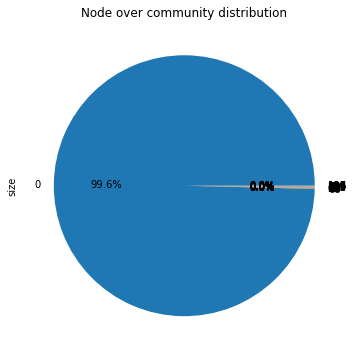

In [42]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [43]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.458467,1946,0.662118,4556,0.135504,290,0.005247,11142,1.0,20799
1,0.348603,290,0.337882,3493,0.113728,1409,0.004733,290,1.0,38882
2,0.341022,6094,0.031396,11142,0.108523,297,0.004519,763,1.0,18143
3,0.324239,11142,0.020747,763,0.107152,11142,0.003804,3684,1.0,83897
4,0.259415,297,0.020487,6094,0.101428,121,0.003612,6094,1.0,5315
5,0.217294,763,0.020096,3684,0.101090,763,0.003428,121,1.0,70172
6,0.209470,1409,0.019340,290,0.095745,6094,0.003315,1409,1.0,70126
7,0.208051,2841,0.017910,1946,0.094643,2926,0.003228,297,1.0,76080
8,0.197511,18060,0.016054,1465,0.093651,1149,0.003115,1946,1.0,78512
9,0.195889,2926,0.015453,6101,0.092679,3684,0.003026,2926,1.0,40726


No timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000324,31301,0.000002,31300,0.000268,31300,0.000020,31301,0.0,31301
1,0.000162,31300,0.000000,31301,0.000078,31301,0.000014,31300,0.0,31300


No timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000365,5988,0.000041,5988,0.000230,5988,0.000026,5988,0.0,5988
1,0.000041,3213,0.000000,3213,0.000001,3213,0.000012,3213,NaN,3213


No timestamp data available
Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000446,31285,0.0,31285,0.000548,31285,0.000015,31285,0.333333,31285


No timestamp data available
Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000162,23085,0.000041,23085,0.000546,23085,0.000031,23085,0.0,23085
1,0.000041,23086,0.000000,23086,0.000003,23086,0.000015,23086,NaN,23086


No timestamp data available
Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.000243,37777,0.0,37777,0.000731,37777,0.000019,37777,0.333333,37777
1,0.000122,50086,0.0,50086,0.000259,50086,0.000012,50086,0.000000,50086


No timestamp data available
